# Introduction to Dimension Reduction

-----

When confronted with a large, multi-dimensional data set, one approach to simplify any subsequent analysis is to reduce the number of dimensions that must be processed. In some cases, dimensions can be removed from analysis based on business logic. More generally, however, we can employ machine learning to seek out relationships between the original dimensions (or columns of a DataFrame) to identify new dimensions that better capture the inherent relationships within the data.

In this notebook, we explore how to effectively use [dimension reduction][dr] to reduce the number of features in a given data set. Dimension reduction is generally an _unsupervised learning_ technique, and the reduction in features (or dimensions) can be important for a number of reasons. First, fewer features can increase the performance of machine learning algorithms (since there is less data to process). Second, the results may be more robust since dimensions that contain less information can be excluded (thus an algorithm will be forced to focus on the most important dimensions or features). In this notebook, we will focus on identifying those dimensions (or features) that contain the most _signal_ or information so that algorithms can focus on just those dimensions.

While there are a number of algorithms that have been developed to perform dimension reduction, the most popular technique is [principal component analysis][pca] or PCA. PCA is an important tool for exploratory data analysis, since PCA can quickly identify the most relevant features. In mathematical terms, PCA is used to identify the eigenvalues and [eigenvectors][ev] of a system of linear equations that specify a transformation into a new dimensional space. These eigenvalues contain the _expected variance_, or amount of the underlying signal, in the data and thus provide insight into the new dimensions (specified by the eigenvectors) that contain the most information. Thus, we can select a subset of the new dimensions to reduce the dimensionality of our data set. As we will see in this notebook, [implementing PCA][skpca] in Python is quite easy when using the scikit learn library.

-----
[ev]: https://en.wikipedia.org/wiki/Eigenvector
[skpca]: http://scikit-learn.org/stable/modules/decomposition.html
[pca]: https://en.wikipedia.org/wiki/Principal_component_analysis
[dr]: https://en.wikipedia.org/wiki/Dimensionality_reduction


## Table of Contents

[Principal Component Analysis](#Principal-Component-Analysis)

[PCA: Iris Data](#PCA:-Iris-Data)
- [PCA: Feature Construction](#PCA:-Feature-Construction)
- [PCA: Application for Machine Learning](#PCA:-Application-for-Machine-Learning)

[Factor Analysis](#Factor-Analysis)

[Demonstrating Machine Learning](#Demonstrating-Machine-Learning)

[PCA: Handwritten Digits](#PCA:-Handwritten-Digits)

- [PCA: Fractional of Explained Variance](#PCA:-Fractional-of-Explained-Variance)
- [PCA: Visualization of Components](#PCA:-Visualization-of-Components)
- [PCA: Data Reconstruction](#PCA:-Data-Reconstruction)
- [PCA: Covariance Matrix](#PCA:-Covariance-Matrix)

[Dimensional Reduction: Technique Comparison](#Dimensional-Reduction:-Technique-Comparison)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global fiugure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Principal Component Analysis

The standard technique to perform dimensional reduction is principal component analysis, or PCA. Mathematically, we can derive PCA by using linear algebra to solve a set of linear equations. This process effectively rotates the data into a new set of dimensions, and also provides a ranking of each new feature's importance. Thus, by employing PCA, we can often identify a reduced set of features that we can use to perform machine learning, while retaining the majority of the signal we wish to model. This can result in faster computations and reliable models since we have reduced the amount of noise used to train the model.

The following code sample and associated figure demonstrate principal component analysis. The first Code cell generates a distribution of data that are spread out in the original space. This is done by generating 2500 points that lie along the $y=x$ line with added noise. Next, we display the _expected principal components_ by drawing a new coordinate system over the data (this corresponds to transforming the original coordinate system in the same manner we transformed the original, random data).

-----

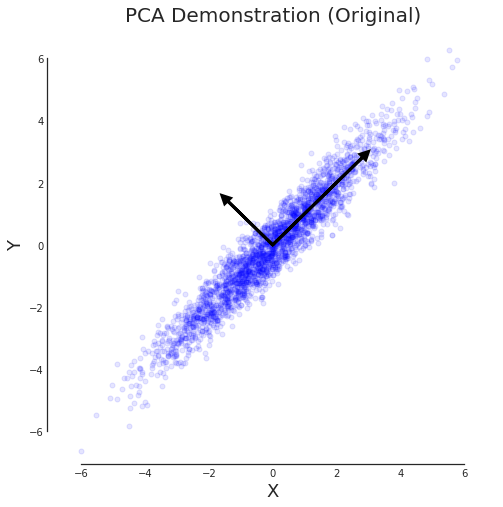

In [2]:
# Define random state
rng = np.random.RandomState(23)

# Number of points to plot
num_pts = 2500

# Plot mask as image
fig, axs = plt.subplots(figsize=(8, 8))

# Generate points
x = rng.normal(0, 2.5, num_pts)
y = x + rng.normal(0, 0.75, num_pts)

# Define new cordinate axes, rotated 45 degrees
theta1 = np.deg2rad(45.0)
theta2 = np.deg2rad(135.0)

# Rotate points and plot
xp = x*np.cos(theta1)
yp = y*np.sin(theta1)
axs.scatter(xp, yp, s=25, c='b', alpha=0.1)

# Draw new coordinate system
axs.arrow(0, 0, 4 * np.cos(theta1), 4 * np.sin(theta1), 
          lw=3, fc="k", ec="k", head_width=0.25, head_length=0.25)
axs.arrow(0, 0, 2 * np.cos(theta2), 2 * np.sin(theta2), 
          lw=3, fc="k", ec="k", head_width=0.25, head_length=0.25)

# Decorate plot
axs.set(title='PCA Demonstration (Original)', 
        xlabel='X', xlim=(-7, 7), 
        ylabel='Y', ylim=(-7, 7))
sns.despine(offset=2, trim=True)

------

To demonstrate how PCA affects a data distribution, we can use the PCA transformer in the scikit learn library. The [PCA][skpca] transformer requires one tunable parameter that specifies the target number of dimensions. This value can be arbitrarily selected, perhaps based on prior information, or it can be iteratively determined. After the transformer is created, we fit the model to the data to determine the principal components. Finally, we display the original data in these new, transformed coordinates. 

-----
[skpca]: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

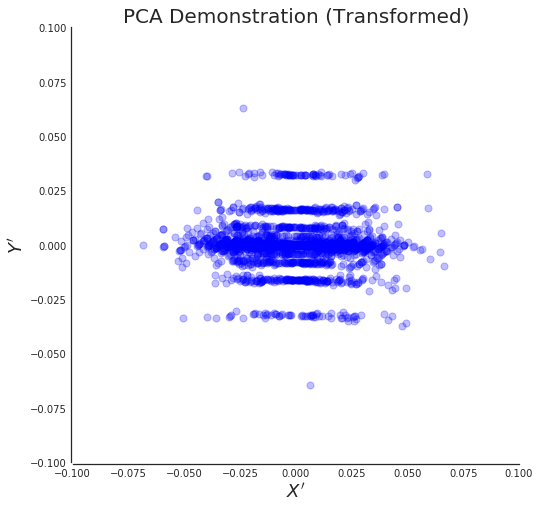

In [3]:
from sklearn.decomposition import PCA

# Compute Principal Components
d = PCA().fit(np.stack((x, y)))

# Plot mask as image
fig, axs = plt.subplots(figsize=(8, 8))

# display data in new components
axs.scatter(d.components_[0], d.components_[1], s=50, c='b', alpha=0.25)

# Decorate plot
axs.set(title='PCA Demonstration (Transformed)', 
        xlabel='$X^{\prime}$', xlim=(-0.1,.1),
        ylabel='$Y^{\prime}$', ylim=(-0.1,.1))
sns.despine(offset=2, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## PCA: Iris Data

To provide a more realistic introduction to principal component analysis, we will use the classic [_Iris_ dataset][id], which is included by default with the Seaborn library (note this same data set is also included with scikit learn). First, we will load the data set into this notebook, and construct a pair plot demonstrating the relationships between the different dimensions (this code and resulting figure are also included in the Seaborn documentation). The four primary dimensions of the data include sepal length, sepal width, petal length, and petal width, which can be seen from the following Iris picture (or type _virginica_).

The data set consists of 150 total measurements of three different types of Iris flowers, equally divided between three classes: Iris Setosa, Iris Versicolor, and Iris Virginica. Before proceeding, we will visualize the different dimensions to explore the importance of the different dimensions and the relationships between them.

-----
[id]: https://en.wikipedia.org/wiki/Iris_flower_data_set

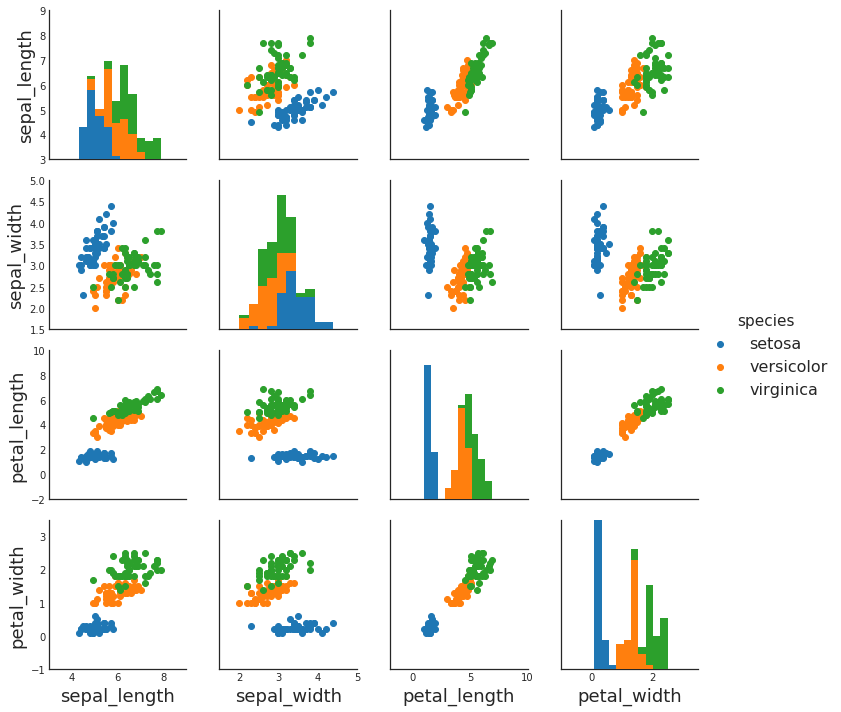

In [4]:
# Load the Iris Data
iris = sns.load_dataset("iris")

# Make pair plot
g = sns.PairGrid(iris, hue="species")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

axes = g.axes

# Axes limits
lim = [(3, 9), (1.5, 5), (-2, 10), (-1, 3.5)]

# Lets explicitly set the axes limits
for i in range(len(lim)):
    for j in range(len(lim)):
        axes[i, j].set_xlim(lim[j])
        axes[i, j].set_ylim(lim[i])

-----

[[Back to TOC]](#Table-of-Contents)

### PCA: Feature Construction

As the previous figure illustrates, the three types of Iris cluster naturally in these dimensions, with minimal overlap. Thus, we can expect that we don't need all four dimensions (or features) to perform machine learning on these data. To formalize this, we can perform dimensionality reduction on these data to identify the most important features in the data.

In the following Code cell, we extract the features array and create a numerical label array before fitting a principal component analysis to the features. Next, we extract the _explained variance ratio_ from the PCA transformer and generate the linear equations that relate the original features to the new principal components, sorted by the explained variance. From the output, it is clear that the first principal component contains the majority of the signal (over 92%), and the first two principal components contain almost 98% of the total variance. This example demonstrates how PCA can reduce the dimensionality of a feature space while retaining the majority of the signal in the data.

-----



In [5]:
# Extract features and labels
features = iris[['sepal_length', 'sepal_width', 
                 'petal_length', 'petal_width']].values
labels = np.array([i//50 for i in range(iris.shape[0])])

# Principal Component Analysis
pca = PCA()

# Fit model to the data
pca.fit(features)

# We can print out rotation matrix and variance associated with each
# projected dimension

vars = pca.explained_variance_ratio_
c_names = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) \
                      for val, name in zip(row, c_names))
    print(output)

Variance:  Projected dimension
------------------------------
92.5%:     0.36 * SepalLength + -0.08 * SepalWidth +  0.86 * PetalLength +  0.36 * PetalWidth
 5.3%:     0.66 * SepalLength +  0.73 * SepalWidth + -0.17 * PetalLength + -0.08 * PetalWidth
 1.7%:    -0.58 * SepalLength +  0.60 * SepalWidth +  0.08 * PetalLength +  0.55 * PetalWidth
 0.5%:    -0.32 * SepalLength +  0.32 * SepalWidth +  0.48 * PetalLength + -0.75 * PetalWidth


-----

[[Back to TOC]](#Table-of-Contents)

### PCA: Application for Machine Learning

In this case, we see that the first two new dimensions capture over 97.5% of the total variance in the data. Thus, by only keeping those two new dimensions, we cut the number of features we must process in half and retain most of the underlying signal that we wish to model. This is the fundamental point about dimension reduction. You *will* lose some signal by removing dimensions, but often the loss is small to insignificant, and the resulting impact on the resulting analysis can be large in terms of overall performance, or for *big data* enabling the computation to even become feasible.

To demonstrate the power of dimension reduction, we explore the impact on classification of this dataset by using SVM on the full four-dimensional data set and on the projected data set. The classification report and confusion matrix demonstrate that SVC classifies the full feature data to a high accuracy.


----

In [6]:
# We analyze the full data by using SVC.

# We want to split our data into training and testing

from sklearn.model_selection import train_test_split

# This is the amount to hold out for 'blind' testing
frac = 0.4

f_train, f_test, l_train, l_test \
    = train_test_split(features, labels, 
                       test_size=frac, random_state=23)

# Next lets try Linear SVM
from sklearn import svm

# Lets build our model and train it all at once
svc = svm.SVC(kernel='linear', C=1E6, random_state=23)
svc.fit(f_train, l_train)

# Now grab the predictions
result = svc.predict(f_test)

# Compute and display score
scr = 100.0 * svc.score(f_test, l_test)
print(f'SVM prediction accuracy = {scr:5.1f}%\n')

# Show classification report
from sklearn.metrics import classification_report

lbls = ['Setosa', 'Versicolor', 'Virginica']

l_pred = svc.predict(f_test)
print(classification_report(l_test, l_pred, \
                            target_names = lbls))

SVM prediction accuracy =  96.7%

             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        21
 Versicolor       0.90      1.00      0.95        18
  Virginica       1.00      0.90      0.95        21

avg / total       0.97      0.97      0.97        60



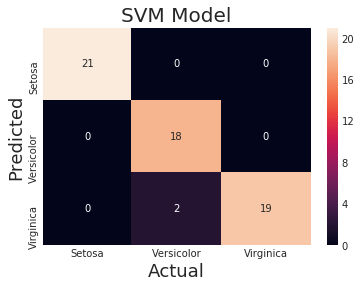

In [7]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test.reshape(l_test.shape[0]), 
             l_pred.reshape(l_test.shape[0]), 
             lbls, 3, 'SVM Model')

-----

We now perform dimension reduction on these data, before performing classification. In the following Code cell, we perform principal component analysis, and explicitly specify that only the top two components should be retained. Thus, our data set is reduced by fifty percent (four features down to two features). Next, we perform the exact same pre-processing, classification, and analysis on these reduced data. This includes a train-test split on the reduced data, fitting the support vector classification estimator, and scoring the result. In the end, our score, the classification report, and the confusion matrix all show the same classification accuracy, demonstrating the importance and power dimension reduction can play in machine learning tasks.

-----

PCA/SVM prediction accuracy =  96.7%

             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        21
 Versicolor       0.90      1.00      0.95        18
  Virginica       1.00      0.90      0.95        21

avg / total       0.97      0.97      0.97        60



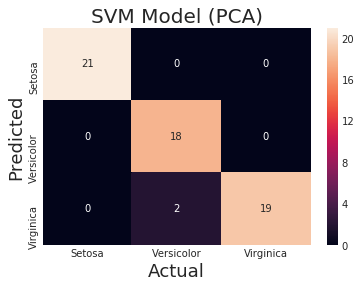

In [8]:
# First we analyze the PCA compressed data by using SVC.

pca = PCA(n_components=2, random_state=23)
features_reduced = pca.fit_transform(features)

# We want to split our data into training and testing

f_train, f_test, l_train, l_test \
    = train_test_split(features_reduced, labels, 
                       test_size=frac, random_state=23)

# Reuse existing model, but fit to new data
svc.fit(f_train, l_train)

# Now grab the predictions
result = svc.predict(f_test)

# Compute and display score
scr = 100.0 * svc.score(f_test, l_test)
print(f'PCA/SVM prediction accuracy = {scr:5.1f}%\n')

# Show classification report
l_pred = svc.predict(f_test)
print(classification_report(l_test, l_pred, \
                            target_names = lbls))

# Call confusion matrix plotting routine
ml.confusion(l_test.reshape(l_test.shape[0]), 
             l_pred.reshape(l_test.shape[0]), 
             lbls, 3, 'SVM Model (PCA)')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used PCA to transform the Iris data and explored the impact of the reduced dimensionality on a simple classification. Now that you have run this notebook once, go back and make the following changes to see how the results change.

1. Change the cross-validation split size, for example change from 80%:20% to 75%:25% and to  50%:50%.
2. Try using the three PCA dimensions for the classification, how do the results change?
3. Try using only the top PCA dimension for the classification, how do the results change?
4. Try using a different dimension reduction technique, such as RandomizedPCA, KernelPCA, or Non-Negative Matrix Factorization.

-----

[[Back to TOC]](#Table-of-Contents)

## Factor Analysis

While PCA is often used to reduce the dimensionality of a data set, another technique that works in much the same way is [factor analysis][wfa]. Factor analysis quantifies the variability seen in a data set in terms of a _potentially_ smaller number of unobserved variables (known as **latent** variables). Factor analysis can be useful when exploring a data set, as it can be used to find a reduced set of features that still contain the majority of the signal. Unlike PCA, however, the reduced set of features is not guaranteed to be orthogonal.

We can apply factor analysis with the scikit learn library by using the [`FactorAnalysis`][skfa] in the `decomposition` module. This generative model takes several hyperparameters, including the number of components to keep (`n_components`). This estimator is demonstrated in the following Code cell, where we compute the _latent_ features for the Iris data. In this case, we see two latent variables are created (since the other two have all zero coefficients), but note that these new linear combinations are different than those created by the PCA estimator. 

-----

[wfa]: https://en.wikipedia.org/wiki/Factor_analysis
[skfa]: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html

In [9]:
from sklearn.decomposition import FactorAnalysis

factor = FactorAnalysis().fit(features)

pd.DataFrame(factor.components_, columns=c_names)

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,0.706989,-0.158005,1.654236,0.70085
1,0.115161,0.159635,-0.044321,-0.01403
2,-0.000000,0.000000,0.000000,0.00000
3,-0.000000,0.000000,0.000000,-0.00000


-----

[[Back to TOC]](#Table-of-Contents)

## PCA: Handwritten Digits

While the Iris data provided a simple data set with which to demonstrate PCA, it is hard to demonstrate the effects of dimensional reduction with only four primary features. As a result, we now switch to a second type of data and explore PCA applied to the handwritten digit data set. First, we will load the data and review some of the samples. These images are eight pixels by eight pixels square, for a total of sixty-four pixels, which is very small for an image (think about your phone's camera which has millions of pixels. When analyzing this data, we treat all pixels in the same position in each image as features. Therefore, the starting dimensionality of these data is sixty-four.

-----

Total number of samples = 1797
Dimensionality of samples = 64


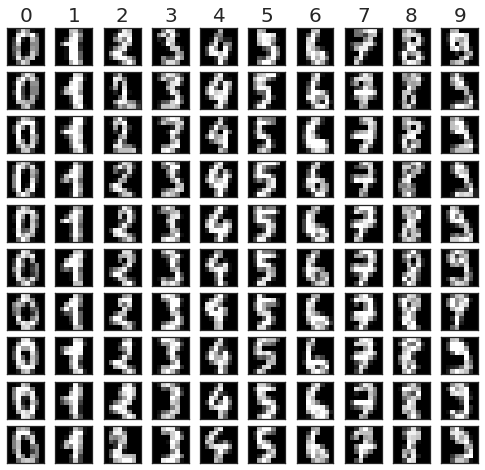

In [10]:
# We have helper code to assist in the loading and plotting of these data
from helper_code import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()
hd.im_plot(x, y, images)

print(f'Total number of samples = {x.shape[0]}')
print(f'Dimensionality of samples = {x.shape[1]}')

-----

With these data loaded, we can now apply PCA to the image data. Since we already imported the PCA transformer, we need to create the transformer, and fit the transformer to the data set. In this case, we specify the parameter `copy=True`, which instructs the `PCA` transformer to copy the input data before computing the PCA transformation. We perform all of these steps in one line, create and fit the transformer.

To demonstrate the application of this transformer, the second Code cell displays the _mean_ image generated when computing the principal components. From this image, some important insights can be gleaned. First, the far left and far right columns (i.e., 0 and 7) have very little signal relative to the center pixels. Second, even the center pixels have varying signal. Thus, from this image alone, we can expect the we can significantly reduce the number of features required to model this data set. How many features should be retained will be determined in the next section of this notebook.

-----

In [11]:
# Compute PCA for these data
pca = PCA(copy=True).fit(x)

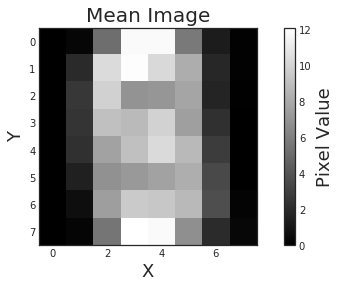

In [12]:
# Plot mean image, from the PCA transformer
fig, ax = plt.subplots(figsize=(10, 4))

# The features are handled as one-dimensional array, 
# so we need to reshape them to get an 8x8 image
im = ax.imshow(pca.mean_.reshape(8, 8)) ;

# Decorate plot
ax.set(title='Mean Image', xlabel='X', ylabel='Y')
ax.set_xticks([0, 2, 4, 6])
ax.set_xticks([0, 2, 4, 6])
fig.colorbar(im, label='Pixel Value') ;

-----

[[Back to TOC]](#Table-of-Contents)

### PCA: Fraction of Explained Variance

When applying PCA to a data set with a large number of features, it can be challenging to quantify how many features to retain. One analytic approach is to the measure the fraction of explained variance added with each new feature. In this manner, we can define an _a priori_ fraction, such as 95%, of the explained variance as a stopping point. 

The following Code cell demonstrates this process with the handwritten digit data set. We generate a cumulative sum of the explained variance, and plot the differential fractional variance added with each new principal component. To make the results clear, the number of dimensions at which we have 75%, 90%, 95%, and 99% of the explained variance are indicated by vertical lines (by using the matplotlib `vlines` function). As the plot demonstrates, ten components we have effectively captured 75% of the original signal, and twenty components have captured 90% of the original signal.

This type of analysis can be extremely helpful in quantifying why a specific number of principal components should be retained for subsequent analysis. For example, the figure shows that forty components retain 99% of the original signal. This means a reduction of sixty-four features to forty components (or 37.5% reduction in dimensions) retains almost the entire original signal. This will speed up later analyses, and potentially improve performance since fewer low signal features are included that could lead to overfitting.

-----

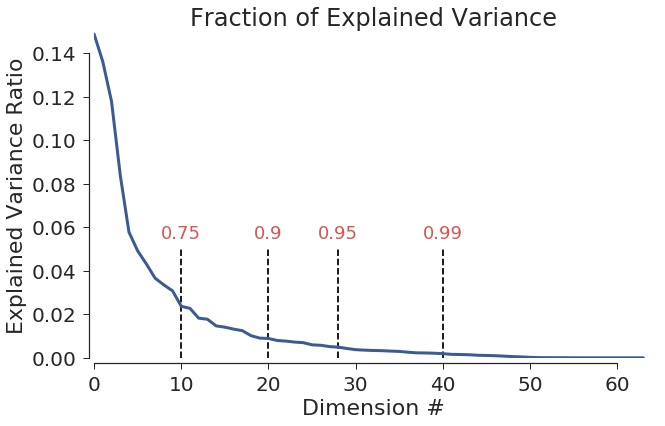

In [13]:
# We compute the cumulative variance
lmts = [0.75, 0.9, 0.95, 0.99]
vars = np.cumsum(pca.explained_variance_ratio_)
vls = np.array([np.argmax(vars > i) for i in lmts])

# Make the plot
sns.set(style="ticks", font_scale=2.0)
fig, ax = plt.subplots(figsize=(10,6))

# Define boundaries
ax.set_xlim(0, 64.0)
ax.set_ylim(0, 0.15)

# Draw lines for the cumulative variance
ax.vlines(vls, 0.0, 0.05, linestyles='dashed')

# Label lines with text markers
for xl, txt in zip(vls, lmts):
    
    ax.text(xl, 0.055, str(txt), fontsize = 18, \
            color=sns.xkcd_rgb["pale red"], \
            horizontalalignment='center')
    
# Now draw the points, with bolder colors.
plt.plot(pca.explained_variance_ratio_, 
         color=sns.xkcd_rgb["denim blue"], 
         linewidth=3)

# Decorate the plot
ax.set_xlabel('Dimension #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Fraction of Explained Variance')

sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

### PCA: Visualization of Components

While the expected variance figure above shows the relative importance of each feature, you can also see the same information by visually inspecting the principal components themselves. In the following cell, we first display ten original images, after which we compute the full set of eigenvectors for the handwritten digit data set. 

We subsequently display the first 60 components sorted in order of decreasing importance. The visual changes are striking, demonstrating how the latter components have less information. This reaffirms what was seen in the fraction of explained variance plot above, where twenty components contained 90% of the original signal. 

-----

Total number of PCA Components = 64


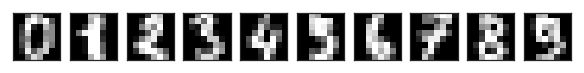

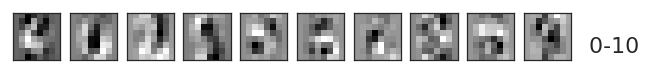

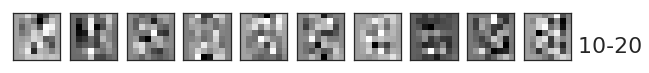

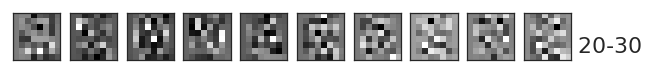

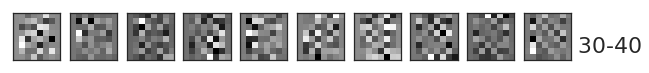

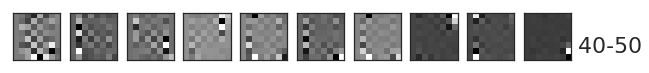

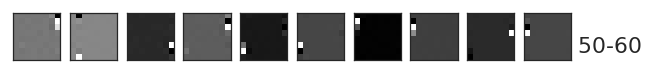

In [14]:
# Display ten representaive images
hd.plot_numbers(x[0:10])

# Now compute full set of components
pca = PCA()
pca.fit_transform(x)
print('Total number of PCA Components = {0}'.format(pca.n_components_))

# Display first 60 components in 6 rows of ten images each.
# Ordered by decreasing eigenvalues
for npc in range(0, 60, 10):
    hd.plot_numbers(pca.components_[npc:npc + 10])
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f'      {npc:6d}-{npc + 10:2d}', rotation=0)

-----

[[Back to TOC]](#Table-of-Contents)

### PCA: Data Reconstruction

We can vary the number of components in PCA and see the quality of the reconstructed data. In the following cell, we display a set of ten images and in subsequent rows we display the reconstructed versions of these ten images with progressively more components. When only using a few components (the first few rows), the reconstruction is blurry and lacks fidelity. Once we get to around ten components, however, the reconstruction is fairly good. This indicates that the full set of 64 components is clearly not needed to represent this data (think about all of the _black_ or zero valued pixels in the original images).

-----

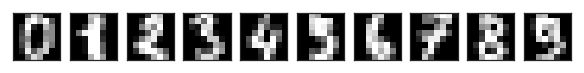

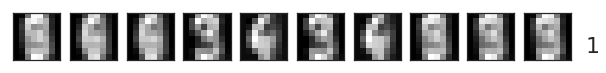

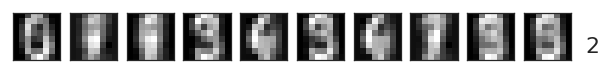

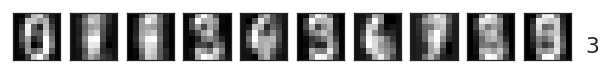

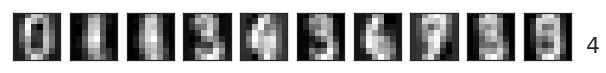

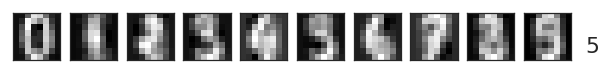

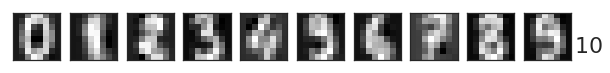

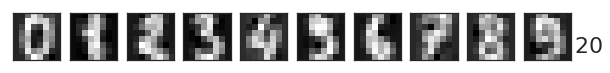

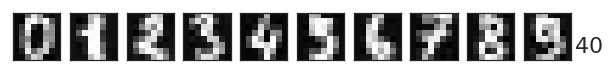

In [15]:
hd.plot_numbers(x[0:10])

ncps = [1, 2, 3, 4, 5, 10, 20, 40]
for npc in ncps:
    pca = PCA(n_components=npc, copy=True)
    tx = pca.fit_transform(x)
    hd.plot_numbers(pca.inverse_transform(tx)[0:10])
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('{0:6d}'.format(npc), rotation=0)


-----

[[Back to TOC]](#Table-of-Contents)

### PCA: Covariance Matrix

We can display the covariance matrix that is computed during the determination of the eigenvectors. This matrix is stored as a 64 x 64 element array (recall that the images themselves are stored as sixty-four element arrays). The covariance matrix encodes the relationship between each pixel in each eigenvector. Thus, it is symmetric about the diagonal, and one can extract the mean image content from this matrix.

-----

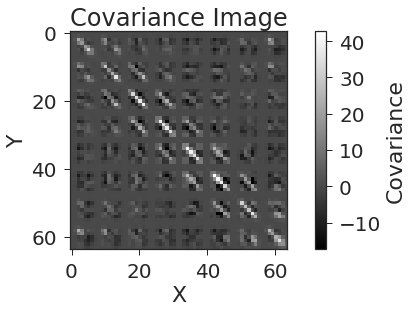

In [16]:
# Compute PCA to get covaraince matrix
pca = PCA(n_components=npc, copy=True)
pca.fit(x)

# Plot mean image, from the PCA transformer
fig, ax = plt.subplots(figsize=(10, 4))

# Display covariance matrix as an image
im = ax.imshow(pca.get_covariance())

# Decorate plot
ax.set(title='Covariance Image', xlabel='X', ylabel='Y')
ax.set_xticks([0, 20, 40, 60])
ax.set_xticks([0, 20, 40, 60])
fig.colorbar(im, label='Covariance') ;

-----

[[Back to TOC]](#Table-of-Contents)

## Dimensional Reduction: Technique Comparison

This notebook has introduced principal component analysis, which is one of, if not the, dominant form of dimension reduction, especially for those who are new to machine learning. In large part this is because it is relatively simple to understand, often works well, and has been used for a long time. However, standard PCA makes several assumptions, including the expectation that the data are linear, that dimensions (or features) that have large variances encode interesting and important signals, and that the principal components are orthogonal. In addition, to compute the principal components, standard PCA requires that a (potentially large) matrix must be inverted. Matrix operations can be computationally intensive, even when using a powerful technique like [singular value decomposition (SVD)][svd]. 

As a result, other techniques have been developed to more effectively deal with more complex dimensional transformations and larger data volumes. In the following cell, we display the transformation computed by several other dimension reduction techniques supported by scikit learn: [randomized PCA][skrpca], [non-negative matrix factorization][sknnmf], [factor analysis][skfa], and [independent component analysis][skica]. While a more complete description of these techniques is beyond the scope of this lesson, we can compute these dimension reduction techniques and compare their components visually.

-----

[svd]: https://en.wikipedia.org/wiki/Singular_value_decomposition
[skrpca]: http://scikit-learn.org/stable/modules/decomposition.html#pca-using-randomized-svd
[sknnmf]: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
[skfa]: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
[skica]: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

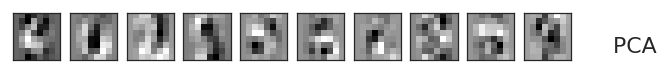

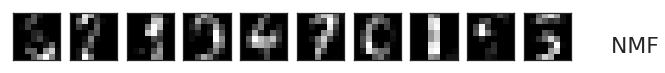

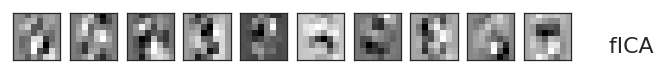

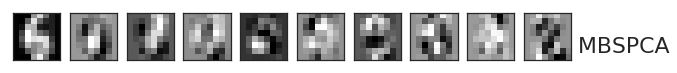

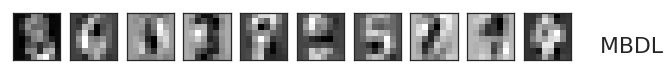

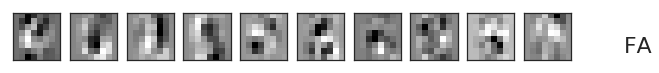

In [17]:
# Principal Component Analysis
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.decomposition import MiniBatchDictionaryLearning
npc = 10

pca = PCA(n_components=npc, copy=True)
nmf = NMF(n_components=npc, init='nndsvda', tol=5e-3)
fica = FastICA(n_components=npc)
mbsp = MiniBatchSparsePCA(n_components=npc)
mbdl = MiniBatchDictionaryLearning(n_components=npc)
fa = FactorAnalysis(n_components=npc, max_iter=2)

adr = [pca, nmf, fica, mbsp, mbdl, fa]
nam = ['PCA', 'NMF', 'fICA', 'MBSPCA', 'MBDL', 'FA']
for dr, nm in zip(adr, nam):
    tx = dr.fit(x)
    hd.plot_numbers(dr.components_)
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('{0:>20s}'.format(nm), rotation=0)    

-----

### Signal Reconstruction

Some dimensional reduction techniques provide signal reconstruction methods, or in other words these techniques are invertible. For example, PCA develops a transformation method that is invertible, even when the dimensions (or features) have been eliminated from the data. For these techniques, we can perform dimension reduction, which compresses the original signal, and next apply an inverse transform to attempt to recover the original signal. This approach allows for a quantification of the accuracy of the reconstruction, and also demonstrates the fidelity of the compressed representation.

In the following Code cell, we demonstrate signal reconstruction by using the previously constructed PCA, NMF, and FastICA transformers on the first ten images in the handwritten digit data set. We transform the data, and immediately apply an inverse transform, before plotting the digit images. While the reconstructions are not perfect, recall we only kept ten components (or features) during the original transformation out of the total of sixty-four. As a result, the reconstruction is based off of a little more than fifteen percent of the original signal. This demonstrates the power of these techniques in capturing most of the signal from a small subset of the full feature data.

-----

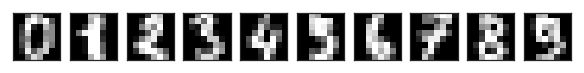

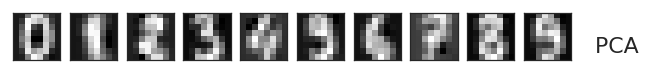

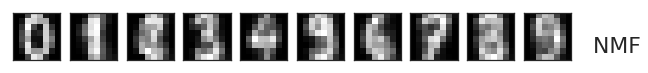

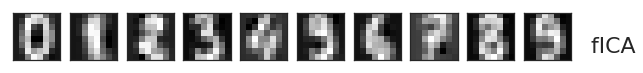

In [18]:
adr = [pca, nmf, fica]
nam = ['PCA', 'NMF', 'fICA']

hd.plot_numbers(x[:10])

for dr, nm in zip(adr, nam):
    tx = dr.fit(x)
    hd.plot_numbers(dr.inverse_transform(dr.transform(x[:10])))
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('{0:>15s}'.format(nm), rotation=0)

-----

<font color='red' size = '5'> Student Exercise </font>


In the preceding cells, we used PCA to reduce the dimensionality of the digit data. Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the number of components in the analysis of the fake handwritten data. How does this change the reconstruction?

2. Try multiplying the covariance matrix by several original images. What does the resulting _image_ look like?

3. Try changing the standard PCA we used in this notebook to incremental PCA. What benefits does this new approach provide? How do the results differ with standard PCA?

-----

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. Wikipedia article on [dimension reduction][1]
1. Scikit learn documentation on [decomposing signals][2]
2. A nice tutorial on [PCA][3]

-----

[1]: https://en.wikipedia.org/wiki/Dimensionality_reduction
[2]: http://scikit-learn.org/stable/modules/decomposition.html
[3]: https://arxiv.org/pdf/1404.1100.pdf

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode